In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')

# Running the Model

In [3]:
# Read data files
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
    's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad')
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250729.pre')
with celltrip.utility.general.open_s3_or_local('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250729.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# Subset and preprocess the data
samples = adatas[0].obs.index  # Use partition cols here to select data
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning=False for lstq pinning
policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250729-0800.weights')

In [4]:
# Run policy to convergence, and get pinning function
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
target_state = env.modalities[env.target_modalities[0]].cpu()
# Get pinning and inverse
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]

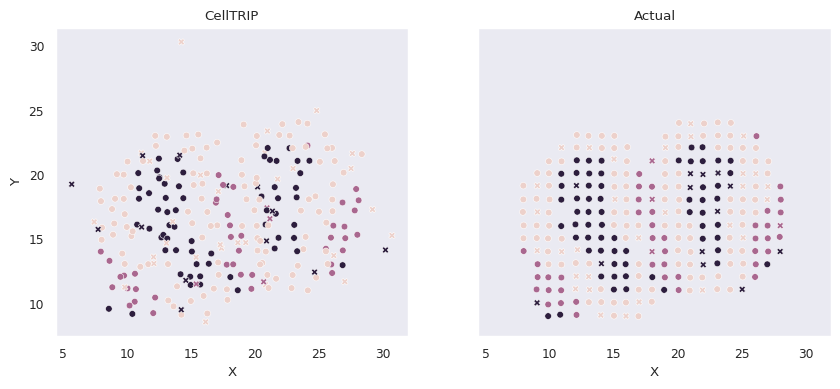

In [5]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = inverse_transform(pinning_function(steady_state))
df[['X_true', 'Y_true']] = inverse_transform(target_state.numpy())
df['Type'] = adatas[0].obs['pattern_gp_label']  # HMRF_k3_b.40
df['Validation'] = ~mask
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', style='Validation', legend=False, ax=axs[1])
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()

# Running out-of-scope data

In [6]:
# Load the external dataset
adata = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad')[0]
# Generate or load preprocessing
# TODO: Save and load mask
preprocessing = celltrip.utility.processing.Preprocessing().load('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250729.pre')
# Subset and preprocess the data
samples = adata.obs.index  # Use partition cols here to select data
m1, = preprocessing.transform(adata[samples].X, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2]).eval().to('cuda')  # pinning=False for lstq pinning
policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250729-0800.weights')

In [7]:
# Run policy to convergence
env.disable_rewards(); env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
# Get pinning and inverse
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]

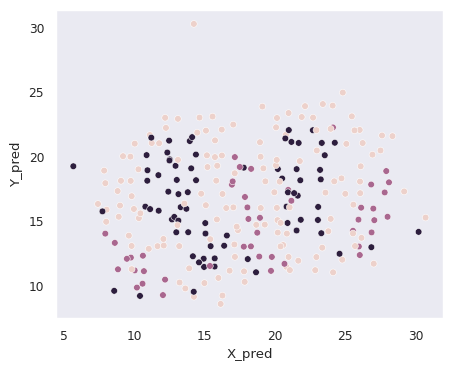

In [8]:
# Plot imputed
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = inverse_transform(pinning_function(steady_state))
df['Type'] = adatas[0].obs['pattern_gp_label']  # HMRF_k3_b.40
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=ax)
fig.show()